# 2 УРОК АНАЛИЗ ПРОДУКТОВЫХ МЕТРИК

## Практика
На прошлом уроке мы научились строить полноценные дашборды и представлять результаты анализа в понятной бизнесу форме — это очень важный навык, необходимый любому аналитику.

На этом занятии мы чуть подробнее поговорим про анализ наиболее важных метрик, которые позволяют с разных сторон оценить то, насколько хорошо работает наш продукт.

На самом деле ранее мы уже считали отдельные показатели — например, метрики вовлечённости пользователей DAU, WAU и MAU, количество заказов, долю отменённых заказов и т.д. Это действительно важные показатели, но часто представители бизнеса в первую очередь обращают внимание на более понятные им показатели, выраженные в денежной форме. Это могут быть выручка, затраты или рентабельность, а также относительные показатели вроде дохода на одного пользователя и среднего чека — всё это тоже важно уметь рассчитывать, чем мы с вами и займёмся.

Кроме того, в конце урока мы обсудим методику расчёта ещё одного важного показателя — Retention rate.

В этот раз вам снова будет предложено написать несколько SQL-запросов и визуализировать их результат с помощью графиков в Redash. Проверяющая система по-прежнему будет оценивать корректность запросов, но сами графики проверяться не будут. 

В конце урока из всех построенных графиков можно будет собрать ещё несколько дашбордов.

Желаем успехов!

# Задача 1.
Начнём с выручки — наиболее общего показателя, который покажет, какой доход приносит наш сервис.

Задание:

Для каждого дня в таблице orders рассчитайте следующие показатели:

Выручку, полученную в этот день.
Суммарную выручку на текущий день.
Прирост выручки, полученной в этот день, относительно значения выручки за предыдущий день.
Колонки с показателями назовите соответственно revenue, total_revenue, revenue_change. Колонку с датами назовите date.

Прирост выручки рассчитайте в процентах и округлите значения до двух знаков после запятой.

Результат должен быть отсортирован по возрастанию даты.

Поля в результирующей таблице: date, revenue, total_revenue, revenue_change

Пояснение: 

Будем считать, что оплата за заказ поступает сразу же после его оформления, т.е. случаи, когда заказ был оформлен в один день, а оплата получена на следующий, возникнуть не могут.

Суммарная выручка на текущий день — это результат сложения выручки, полученной в текущий день, со значениями аналогичного показателя всех предыдущих дней.

При расчёте выручки помните, что не все заказы были оплачены — некоторые были отменены пользователями.

Не забывайте при делении заранее приводить значения к нужному типу данных. Пропущенные значения прироста для самой первой даты не заполняйте — просто оставьте поля в этой строке пустыми.

## Подсказка на случай, если совсем не получается

Для решения задачи вам потребуется информация о заказах из таблицы orders и ценах на товары из таблицы products. Чтобы посчитать выручку для каждого дня, сначала необходимо посчитать стоимость каждого заказа. Это можно сделать, сложив цены входящих в заказ товаров. Чтобы правильно присоединить данные о ценах на товары, списки с содержимым заказов нужно предварительно расширить с помощью функции unnest. После того как для каждого дня будет посчитана суммарная стоимость всех заказов (выручка), с помощью оконных функций можно посчитать сумму нарастающим итогом (общую выручку) и прирост выручки (разницу между выручкой в текущий день и выручкой в предыдущий день, делённую на выручку в предыдущий день).

После того как составите запрос, попробуйте визуализировать результаты и постройте графики, отражающие динамику рассчитанных показателей.

In [ ]:
# Мое РЕШЕНИЕ
SELECT date, sum(price) AS revenue,
    sum(sum(price)) over(ORDER BY date) AS total_revenue,
     ROUND(100.0*(sum(price)/LAG(sum(price),1) OVER ()),2)-100 AS revenue_change

FROM
    (SELECT date, order_id, product_id,price
    FROM
        (SELECT creation_time::date as date,
            order_id, UNNEST(product_ids) as product_id
        FROM orders
        WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action = 'cancel_order'))t1
    JOIN products
    USING(product_id))t2
GROUP BY 1
ORDER BY 1

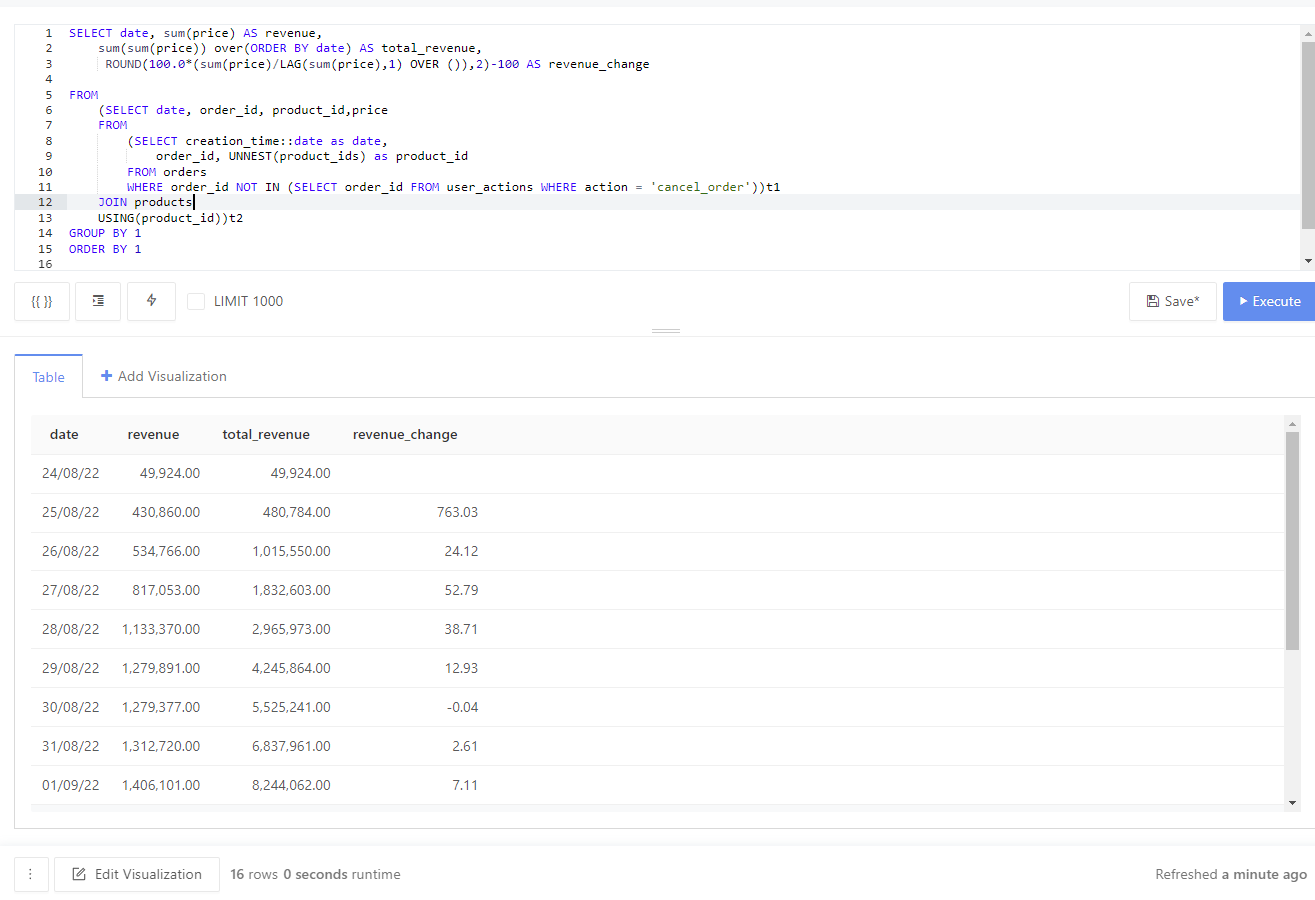

In [ ]:
# вариант подсказка после решения
SELECT date,
       revenue,
       sum(revenue) OVER (ORDER BY date) as total_revenue,
       round(100 * (revenue - lag(revenue, 1) OVER (ORDER BY date))::decimal / lag(revenue, 1) OVER (ORDER BY date),
             2) as revenue_change
FROM   (SELECT creation_time::date as date,
               sum(price) as revenue
        FROM   (SELECT creation_time,
                       unnest(product_ids) as product_id
                FROM   orders
                WHERE  order_id not in (SELECT order_id
                                        FROM   user_actions
                                        WHERE  action = 'cancel_order')) t1
            LEFT JOIN products using (product_id)
        GROUP BY date) t2

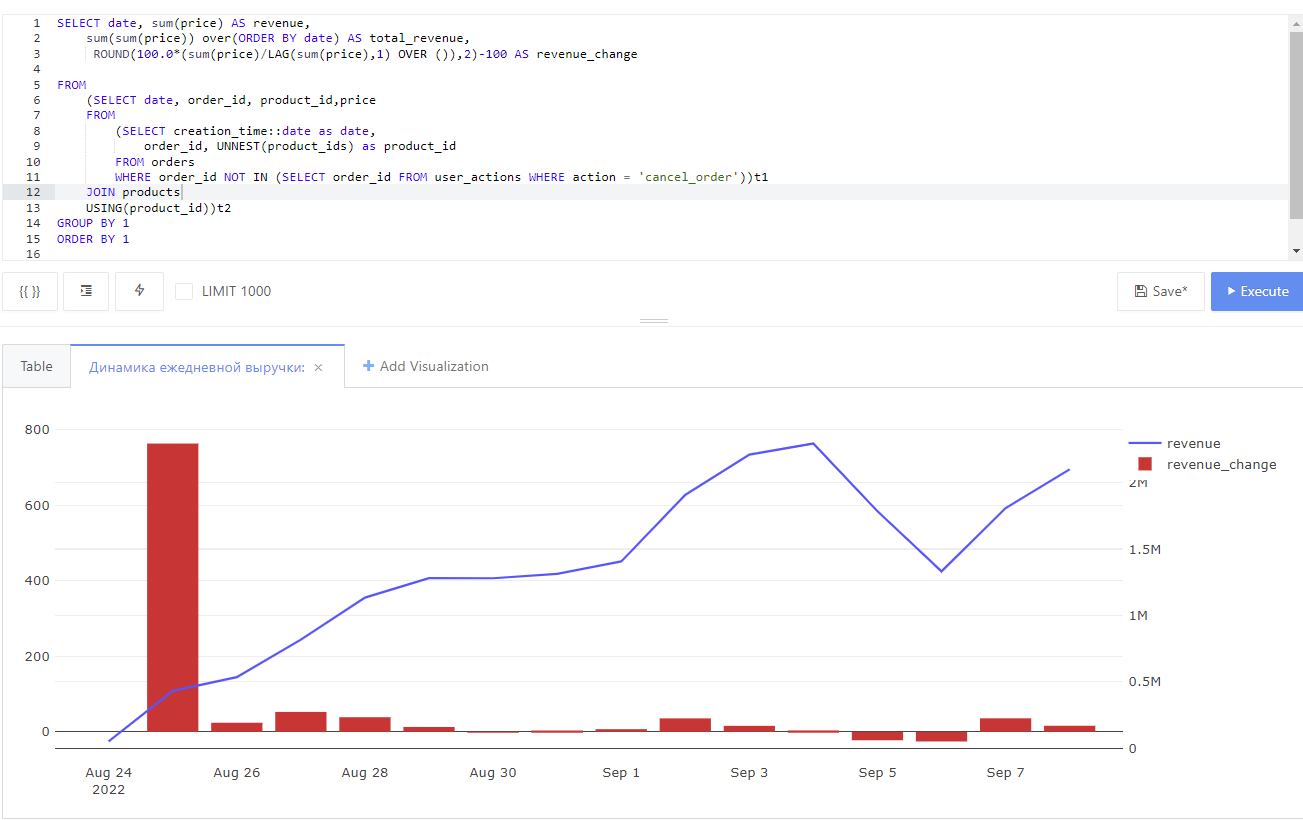

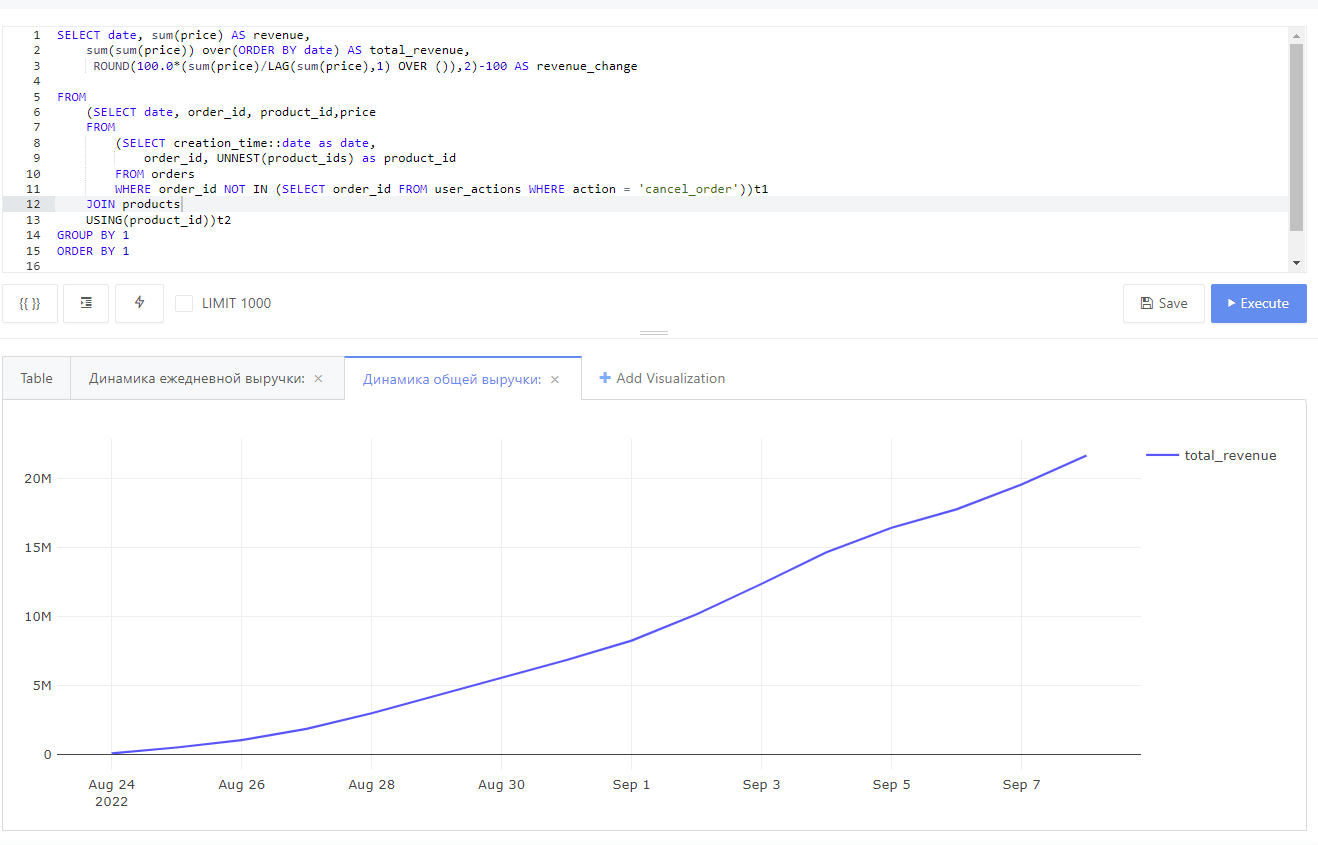

###### Проанализируйте построенные графики и попробуйте ответить на следующие вопросы:

    В какие дни наблюдалось заметное снижение ежедневной выручки? 
    
    С чем это могло быть связано? (чтобы установить причину падения выручки, можете сопоставить текущие графики с графиками на дашборде из прошлого урока)

# Задача 2.
Теперь на основе данных о выручке рассчитаем несколько относительных показателей, которые покажут, сколько в среднем потребители готовы платить за услуги нашего сервиса доставки. Остановимся на следующих метриках:

1. **ARPU (Average Revenue Per User)** — средняя выручка на одного пользователя за определённый период.

2. **ARPPU (Average Revenue Per Paying User)** — средняя выручка на одного платящего пользователя за определённый период.

3. **AOV (Average Order Value)** — средний чек, или отношение выручки за определённый период к общему количеству заказов за это же время.

Если за рассматриваемый период сервис заработал 100 000 рублей и при этом им пользовались 500 уникальных пользователей, из которых 400 сделали в общей сложности 650 заказов, тогда метрики будут иметь следующие значения:
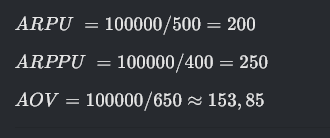

**Задание:**

Для каждого дня в таблицах orders и user_actions рассчитайте следующие показатели:

Выручку на пользователя (ARPU) за текущий день.
Выручку на платящего пользователя (ARPPU) за текущий день.
Выручку с заказа, или средний чек (AOV) за текущий день.
Колонки с показателями назовите соответственно arpu, arppu, aov. Колонку с датами назовите date. 

При расчёте всех показателей округляйте значения до двух знаков после запятой.

Результат должен быть отсортирован по возрастанию даты. 

Поля в результирующей таблице: date, arpu, arppu, aov

Пояснение: 

Будем считать, что оплата за заказ поступает сразу же после его оформления, т.е. случаи, когда заказ был оформлен в один день, а оплата получена на следующий, возникнуть не могут.

Платящими будем считать тех пользователей, которые в данный день оформили хотя бы один заказ, который в дальнейшем не был отменен.

При расчёте выручки помните, что не все заказы были оплачены — некоторые были отменены пользователями.

Не забывайте при делении заранее приводить значения к нужному типу данных.

###### Подсказка на случай, если совсем не получается

Для решения задачи необходимо сначала для каждого дня посчитать выручку, число всех пользователей, число платящих пользователей и число заказов. Затем необходимо объединить полученные таблицы и рассчитать все необходимые относительные показатели. Выручку мы уже считали в прошлом задании.

После того как составите запрос, попробуйте визуализировать результаты и постройте график, отражающий динамику рассчитанных показателей.



In [ ]:
# МОЕ РЕШЕНИЕ
SELECT date, ROUND(1.0*revenue/count_users,2) AS arpu,
    ROUND(1.0*revenue/count_pays_users,2) AS arppu, aov
FROM 
    (SELECT date, COUNT(DISTINCT(order_id)) AS count_orders, sum(price) AS revenue, ROUND(1.0*sum(price)/COUNT(DISTINCT(order_id)),2) AS aov
    FROM
        (SELECT creation_time::date as date,
                order_id, UNNEST(product_ids) as product_id
        FROM orders
        WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action = 'cancel_order'))t1
        JOIN products
        USING(product_id)
    GROUP BY 1)z1
LEFT JOIN
    (SELECT time::date AS date, COUNT(DISTINCT(user_id)) as count_users
    FROM user_actions
    GROUP BY 1)z2
USING(date)
LEFT JOIN
    (SELECT time::date AS date, COUNT(DISTINCT(user_id)) as count_pays_users
    FROM user_actions
    WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action = 'cancel_order')
    GROUP BY 1)z3
USING(date)
# GROUP BY 1,2,3,4 ненужная строка .. но почемуто без нее глючило
ORDER BY 1

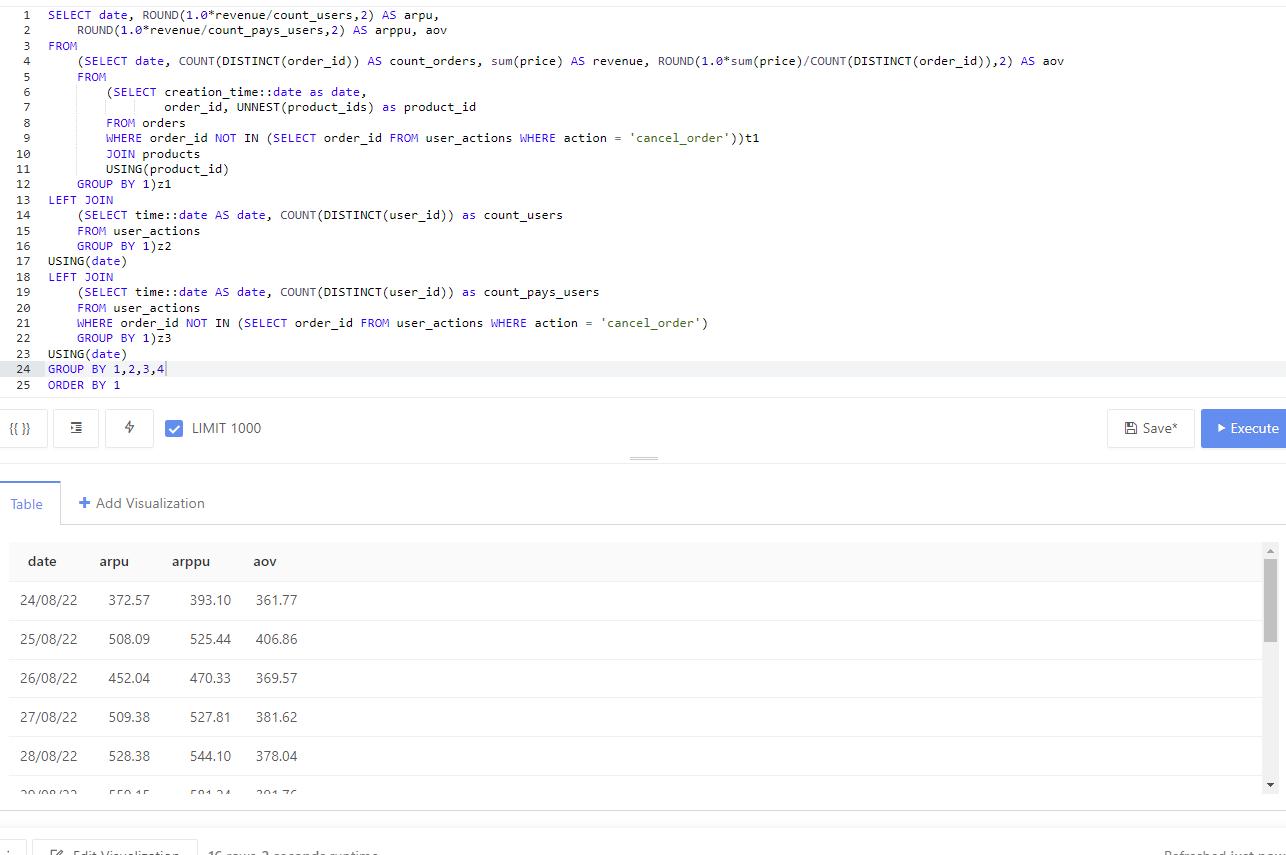

In [ ]:
# вариант подсказка после решения
SELECT date,
       round(revenue::decimal / users, 2) as arpu,
       round(revenue::decimal / paying_users, 2) as arppu,
       round(revenue::decimal / orders, 2) as aov
FROM   (SELECT creation_time::date as date,
               count(distinct order_id) as orders,
               sum(price) as revenue
        FROM   (SELECT order_id,
                       creation_time,
                       unnest(product_ids) as product_id
                FROM   orders
                WHERE  order_id not in (SELECT order_id
                                        FROM   user_actions
                                        WHERE  action = 'cancel_order')) t1
            LEFT JOIN products using(product_id)
        GROUP BY date) t2
    LEFT JOIN (SELECT time::date as date,
                      count(distinct user_id) as users
               FROM   user_actions
               GROUP BY date) t3 using (date)
    LEFT JOIN (SELECT time::date as date,
                      count(distinct user_id) as paying_users
               FROM   user_actions
               WHERE  order_id not in (SELECT order_id
                                       FROM   user_actions
                                       WHERE  action = 'cancel_order')
               GROUP BY date) t4 using (date)
ORDER BY date

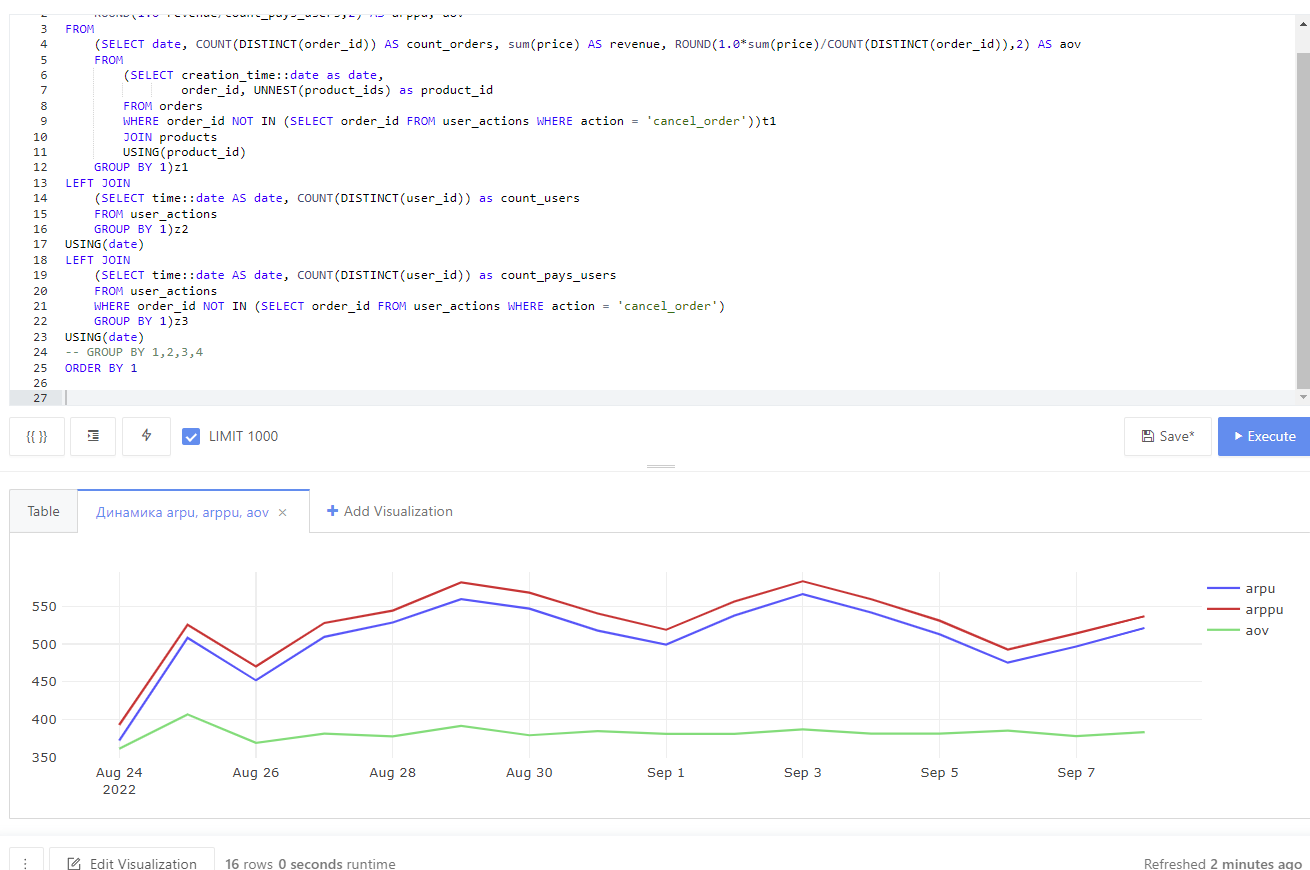

###### Проанализируйте построенный график и попробуйте ответить на следующие вопросы:

1. Какие метрики имеют больший разброс значений на протяжении рассматриваемого периода?

2. Можно ли сказать, что отдельные метрики имеют аномально высокие или аномально низкие значения в отдельные дни?

3. Какой вывод можно сделать о соотношении числа платящих пользователей и всех пользователей сервиса в рассматриваемые дни?

# * Задача 3.
Дополним наш анализ ещё более интересными расчётами — вычислим все те же метрики, но для каждого дня будем учитывать накопленную выручку и все имеющиеся на текущий момент данные о числе пользователей и заказов. Таким образом, получим динамический ARPU, ARPPU и AOV и сможем проследить, как он менялся на протяжении времени с учётом поступающих нам данных.

Задание:

По таблицам orders и user_actions для каждого рассчитайте следующие показатели:

    Накопленную выручку на пользователя (Running ARPU).
    
    Накопленную выручку на платящего пользователя (Running ARPPU).
    
    Накопленную выручку с заказа, или средний чек (Running AOV).
    
    Колонки с показателями назовите соответственно running_arpu, running_arppu, running_aov. Колонку с датами назовите date. 

При расчёте всех показателей округляйте значения до двух знаков после запятой.

Результат должен быть отсортирован по возрастанию даты. 

Поля в результирующей таблице: date, running_arpu, running_arppu, running_aov

###### Пояснение: 

При расчёте числа пользователей и платящих пользователей на текущую дату учитывайте соответствующих пользователей за все предыдущие дни, включая текущий.

Платящими будем считать тех пользователей, которые на текущий день оформили хотя бы один заказ, который в дальнейшем не был отменен.

Будем считать, что оплата за заказ поступает сразу же после его оформления, т.е. случаи, когда заказ был оформлен в один день, а оплата получена на следующий, возникнуть не могут.

При расчёте выручки помните, что не все заказы были оплачены — некоторые были отменены пользователями.

Не забывайте при делении заранее приводить значения к нужному типу данных.

###### Подсказка на случай, если совсем не получается

Для решения этой задачи необходимо дополнить запрос из предыдущего задания и для каждого дня дополнительно рассчитать накопленную выручку, а также накопленное число всех пользователей и отдельно платящих пользователей. Для расчёта числа пользователей с накоплением потребуется информация о новых пользователях и новых платящих пользователях в каждый из рассматриваемых дней. Мы как раз считали это в одной из задач предыдущего урока.

После того как составите запрос, попробуйте визуализировать результаты и постройте график, отражающий динамику рассчитанных показателей.

In [ ]:
# МОЕ !!!
SELECT date, ROUND(1.0*rolling_revenue/rolling_count_users,2) AS running_arpu,
    ROUND(1.0*rolling_revenue/rolling_count_pays_users,2) AS running_arppu, 
    running_aov
FROM 
    (SELECT date, COUNT(DISTINCT(order_id)) AS count_orders, 
    sum(COUNT(DISTINCT(order_id))) over(ORDER BY date) AS rolling_count_orders, 
    sum(price) AS revenue, 
    sum(sum(price)) over(ORDER BY date) AS rolling_revenue, 
    ROUND(1.0*sum(price)/COUNT(DISTINCT(order_id)),2) AS aov,
    ROUND(1.0*sum(sum(price)) over(ORDER BY date)/sum(COUNT(DISTINCT(order_id))) over(ORDER BY date),2) AS running_aov
    FROM
        (SELECT creation_time::date as date,
                order_id, UNNEST(product_ids) as product_id
        FROM orders
        WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action = 'cancel_order'))t1
        JOIN products
        USING(product_id)
    GROUP BY 1)z1
LEFT JOIN
    (SELECT date,
    COUNT(DISTINCT(user_id)) AS new_users,
    SUM(COUNT(DISTINCT(user_id))) OVER(ORDER BY date)::integer AS rolling_count_users
    FROM(
        SELECT MIN(time::date) AS date,
           user_id
        FROM user_actions
        GROUP BY 2)t2
    GROUP BY 1)z2
USING(date)
LEFT JOIN
    (SELECT date,
    COUNT(DISTINCT(user_id)) AS new_user_pay,
    SUM(COUNT(DISTINCT(user_id))) OVER(ORDER BY date)::integer AS rolling_count_pays_users
    FROM(
        SELECT MIN(time::date) AS date,
           user_id
        FROM user_actions
        WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action = 'cancel_order')
        GROUP BY 2)t3
    GROUP BY 1)z3
USING(date)
ORDER BY 1


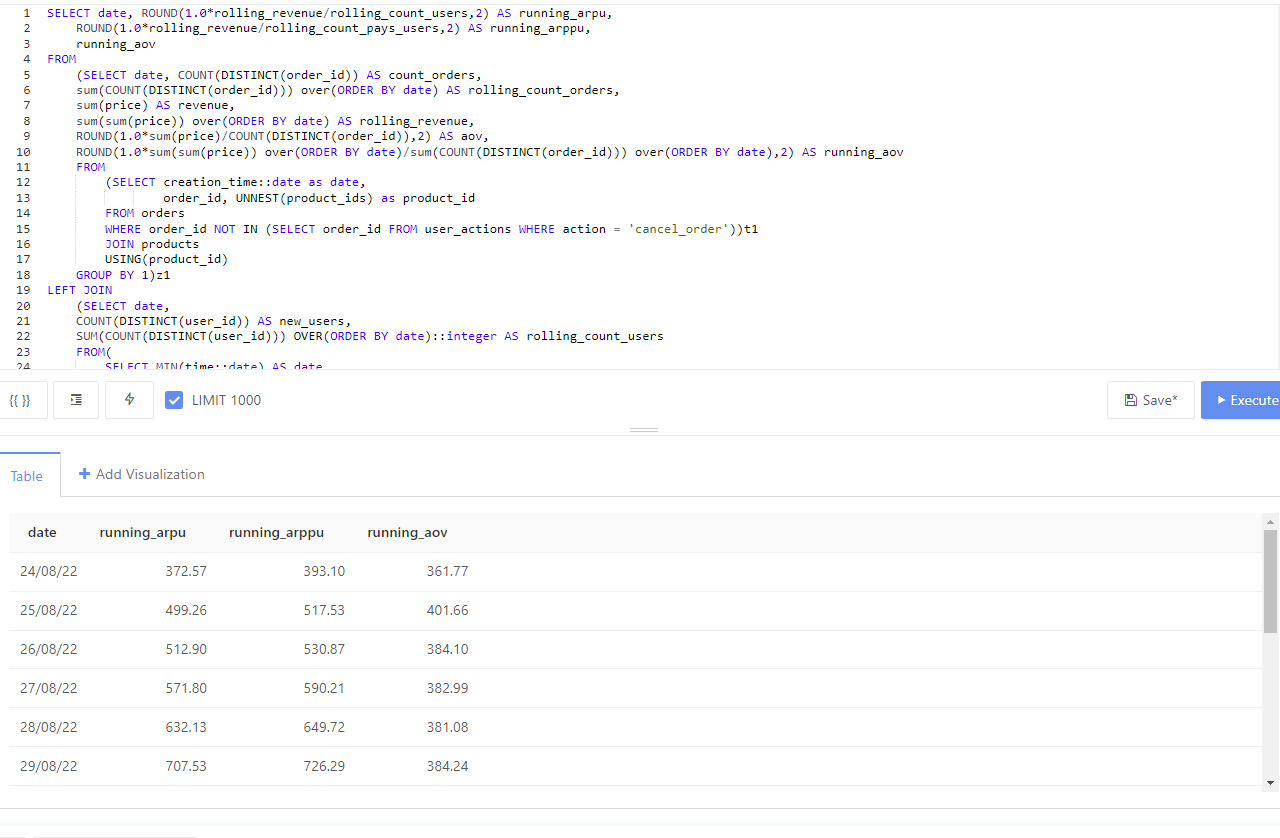

In [ ]:
# Вариант подсказка после решения
SELECT date,
       round(1.0*rolling_revenue/rolling_count_users, 2) as running_arpu,
       round(1.0*rolling_revenue/rolling_count_pays_users, 2) as running_arppu,
       running_aov
FROM   (SELECT date,
               count(distinct(order_id)) as count_orders,
               sum(count(distinct(order_id))) OVER(ORDER BY date) as rolling_count_orders,
               sum(price) as revenue,
               sum(sum(price)) OVER(ORDER BY date) as rolling_revenue,
               round(1.0*sum(price)/count(distinct(order_id)), 2) as aov,
               round(1.0*sum(sum(price)) OVER(ORDER BY date)/sum(count(distinct(order_id))) OVER(ORDER BY date),
                     2) as running_aov
        FROM   (SELECT creation_time::date as date,
                       order_id,
                       unnest(product_ids) as product_id
                FROM   orders
                WHERE  order_id not in (SELECT order_id
                                        FROM   user_actions
                                        WHERE  action = 'cancel_order'))t1 join products using(product_id)
        GROUP BY 1)z1
    LEFT JOIN (SELECT date,
                      count(distinct(user_id)) as new_users,
                      sum(count(distinct(user_id))) OVER(ORDER BY date)::integer as rolling_count_users FROM(SELECT min(time::date) as date,
                                                                                                             user_id
                                                                                                      FROM   user_actions
                                                                                                      GROUP BY 2)t2
               GROUP BY 1)z2 using(date)
    LEFT JOIN (SELECT date,
                      count(distinct(user_id)) as new_user_pay,
                      sum(count(distinct(user_id))) OVER(ORDER BY date)::integer as rolling_count_pays_users FROM(SELECT min(time::date) as date,
                                                                                                                  user_id
                                                                                                           FROM   user_actions
                                                                                                           WHERE  order_id not in (SELECT order_id
                                                                                                                                   FROM   user_actions
                                                                                                                                   WHERE  action = 'cancel_order')
                                                                                                           GROUP BY 2)t3
               GROUP BY 1)z3 using(date)
ORDER BY 1

In [ ]:
# Чужое

WITH 
    revenue_counter AS 
    (SELECT date, revenue, SUM(revenue) OVER(ORDER BY date) total_revenue,
        ROUND(100*(revenue::DECIMAL/(LAG(revenue, 1) OVER(ORDER BY date)) -1),2) revenue_change
    FROM
        (SELECT date, SUM(order_price) revenue
        FROM
            (SELECT DISTINCT order_id, creation_time::DATE date, SUM(price) OVER(PARTITION BY order_id) order_price
            FROM orders,
              LATERAL unnest(product_ids) AS product_id
              LEFT JOIN products USING(product_id)
              WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action = 'cancel_order')) T1
        GROUP BY date) T2),
        
    paying_users AS
    (SELECT date, SUM(new_paying_users::INT) OVER(ORDER BY date) paying_users_sum
    FROM
        (SELECT COUNT(unique_paying_users) new_paying_users, date
        FROM 
            (SELECT DISTINCT user_id unique_paying_users, MIN(time::DATE) date FROM user_actions
            WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action ~~ 'ca%')
            GROUP BY unique_paying_users) T1
        GROUP BY date) T2),
            
   total_users AS
    (SELECT date, SUM(new_users::INT) OVER(ORDER BY date) total_users_sum
    FROM
        (SELECT COUNT(unique_users) new_users, date
        FROM 
            (SELECT DISTINCT user_id unique_users, MIN(time::DATE) date FROM user_actions
            GROUP BY unique_users) T1
            GROUP BY date) T2),
                
    order_counter AS            
    (SELECT date, total_orders, SUM(total_orders::INT) OVER (ORDER BY date) total_orders_sum
    FROM 
        (SELECT time::DATE date, COUNT(DISTINCT order_id) total_orders
        FROM user_actions 
        WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action ~~ 'ca%')
        GROUP BY time::DATE) T1)
    
SELECT date, ROUND(total_revenue::DECIMAL/total_users_sum, 2) Running_ARPU,
    ROUND(total_revenue::DECIMAL/paying_users_sum, 2) Running_ARPPU,
    ROUND(total_revenue::DECIMAL/total_orders_sum, 2) Running_AOV
FROM 
    (SELECT date, total_revenue, total_users_sum, paying_users_sum, total_orders_sum
    FROM revenue_counter 
        JOIN total_users USING(date)
        JOIN paying_users USING(date)
        JOIN order_counter USING(date)) CORE_QUERY
ORDER BY date

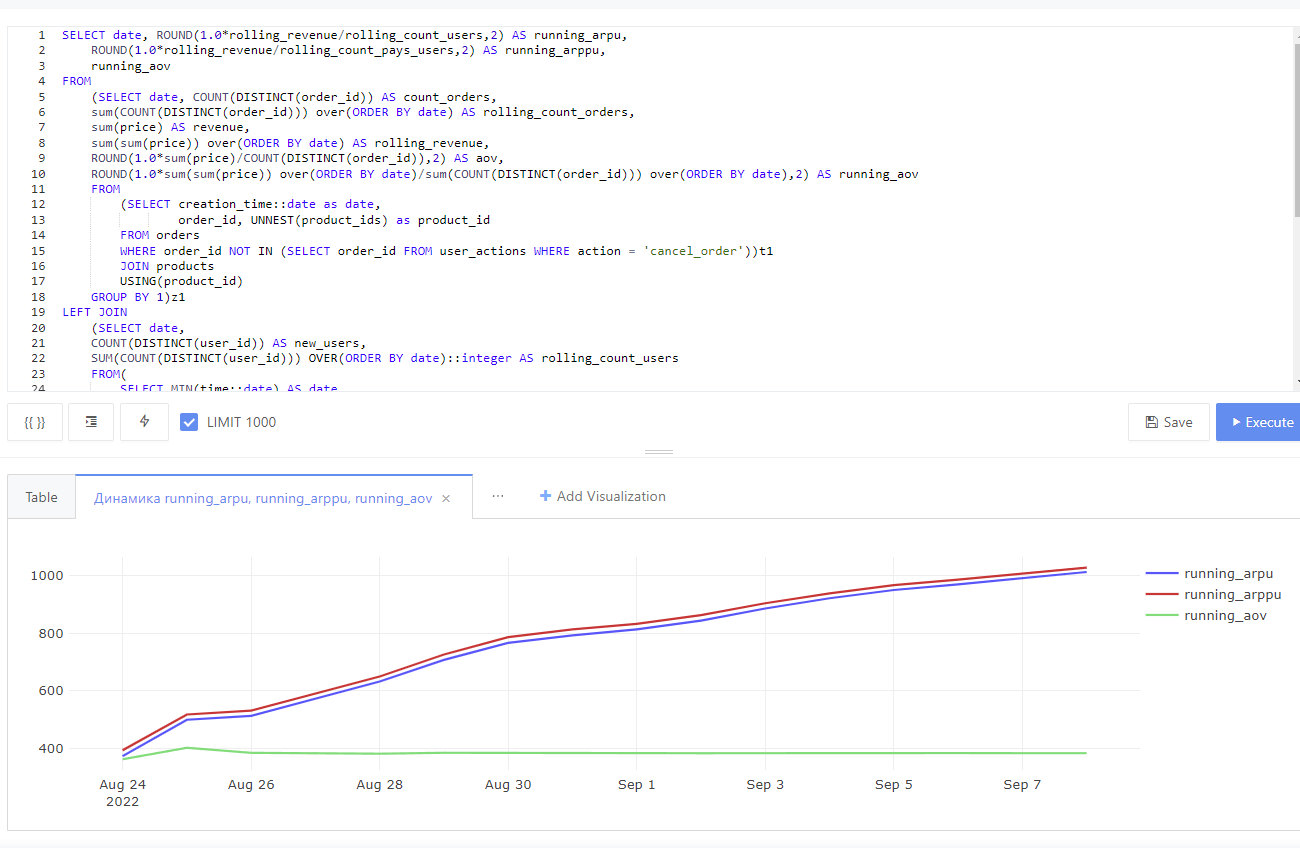

###### Проанализируйте построенный график и попробуйте ответить на следующие вопросы:

1. Какая в целом динамика у рассчитанных метрик? Они растут, падают или имеют примерно одинаковое значение в каждый из дней?

2. Можно ли, учитывая динамику рассчитанных метрик, предположить, что со временем растёт число заказов на одного пользователя?

# Задача 4.
Давайте посчитаем те же показатели, но в другом разрезе — не просто по дням, а по дням недели.

Задание:

Для каждого дня недели в таблицах orders и user_actions рассчитайте следующие показатели:

    Выручку на пользователя (ARPU).
    Выручку на платящего пользователя (ARPPU).
    Выручку на заказ (AOV).
При расчётах учитывайте данные только за период с 26 августа 2022 года по 8 сентября 2022 года включительно — так, чтобы в анализ попало одинаковое количество всех дней недели (ровно по два дня).

В результирующую таблицу включите как наименования дней недели (например, Monday), так и порядковый номер дня недели (от 1 до 7, где 1 — это Monday, 7 — это Sunday).

Колонки с показателями назовите соответственно arpu, arppu, aov. Колонку с наименованием дня недели назовите weekday, а колонку с порядковым номером дня недели weekday_number.

При расчёте всех показателей округляйте значения до двух знаков после запятой.

Результат должен быть отсортирован по возрастанию порядкового номера дня недели.

Поля в результирующей таблице: 

weekday, weekday_number, arpu, arppu, aov

Пояснение: 

Будем считать, что оплата за заказ поступает сразу же после его оформления, т.е. случаи, когда заказ был оформлен в один день, а оплата получена на следующий, возникнуть не могут.

Платящими будем считать тех пользователей, которые в данный день оформили хотя бы один заказ, который в дальнейшем не был отменен.

При расчёте выручки помните, что не все заказы были оплачены — некоторые были отменены пользователями.

Не забывайте при делении заранее приводить значения к нужному типу данных.

В этой задаче порядковый номер дня недели необходим для того, чтобы дни недели были расположены на графике слева направо в правильном порядке — не по возрастанию наименования, а по возрастанию порядкового номера. Для получения корректной визуализации в настройках оси X необходимо отключить сортировку, установленную по умолчанию.

Получить наименование дня недели из колонки с датой или отметкой времени можно с помощью функции to_char:

In [ ]:
SELECT to_char(TIMESTAMP '2023-01-13', 'Day')

Результат:
Wednesday

Для выделения порядкового номера для недели можно использовать функцию DATE_PART с параметром 'isodow'.

###### Подсказка на случай, если совсем не получается

Для решения задачи необходимо проделать все те же операции, что и в предыдущем задании, только в этот раз для дней недели. Дополнительно необходимо правильно задать фильтрацию по дате, чтобы в анализ попало ровно по два одинаковых дня недели.

После того как составите запрос, попробуйте визуализировать результаты и постройте график, отражающий динамику рассчитанных показателей.

In [ ]:
# МОЕ
SELECT date AS weekday,
     weekday_number,
       round(revenue::decimal / users, 2) as arpu,
       round(revenue::decimal / paying_users, 2) as arppu,
       round(revenue::decimal / orders, 2) as aov
FROM   (SELECT  to_char(creation_time, 'Day') as date,
                extract(isodow from creation_time) AS weekday_number,
               count(distinct order_id) as orders,
               sum(price) as revenue
        FROM   (SELECT order_id,
                    creation_time,
                       unnest(product_ids) as product_id
                FROM   orders
                WHERE  (order_id not in (SELECT order_id
                                        FROM   user_actions
                                        WHERE  action = 'cancel_order')) AND creation_time BETWEEN '2022-08-26' AND '2022-09-09'
                ) t1
            LEFT JOIN products using(product_id)
        GROUP BY date, 2) t2
    LEFT JOIN (SELECT to_char(time, 'Day') as date,
                    
                      count(distinct user_id) as users
               FROM   user_actions
               WHERE  time BETWEEN '2022-08-26' AND '2022-09-09'
               GROUP BY date) t3 using (date)
    LEFT JOIN (SELECT to_char(time, 'Day') as date,
                      count(distinct user_id) as paying_users
               FROM   user_actions
               WHERE  (order_id not in (SELECT order_id
                                       FROM   user_actions
                                       WHERE  action = 'cancel_order')) AND time BETWEEN '2022-08-26' AND '2022-09-09'
               GROUP BY date) t4 using (date)
    
ORDER BY 2

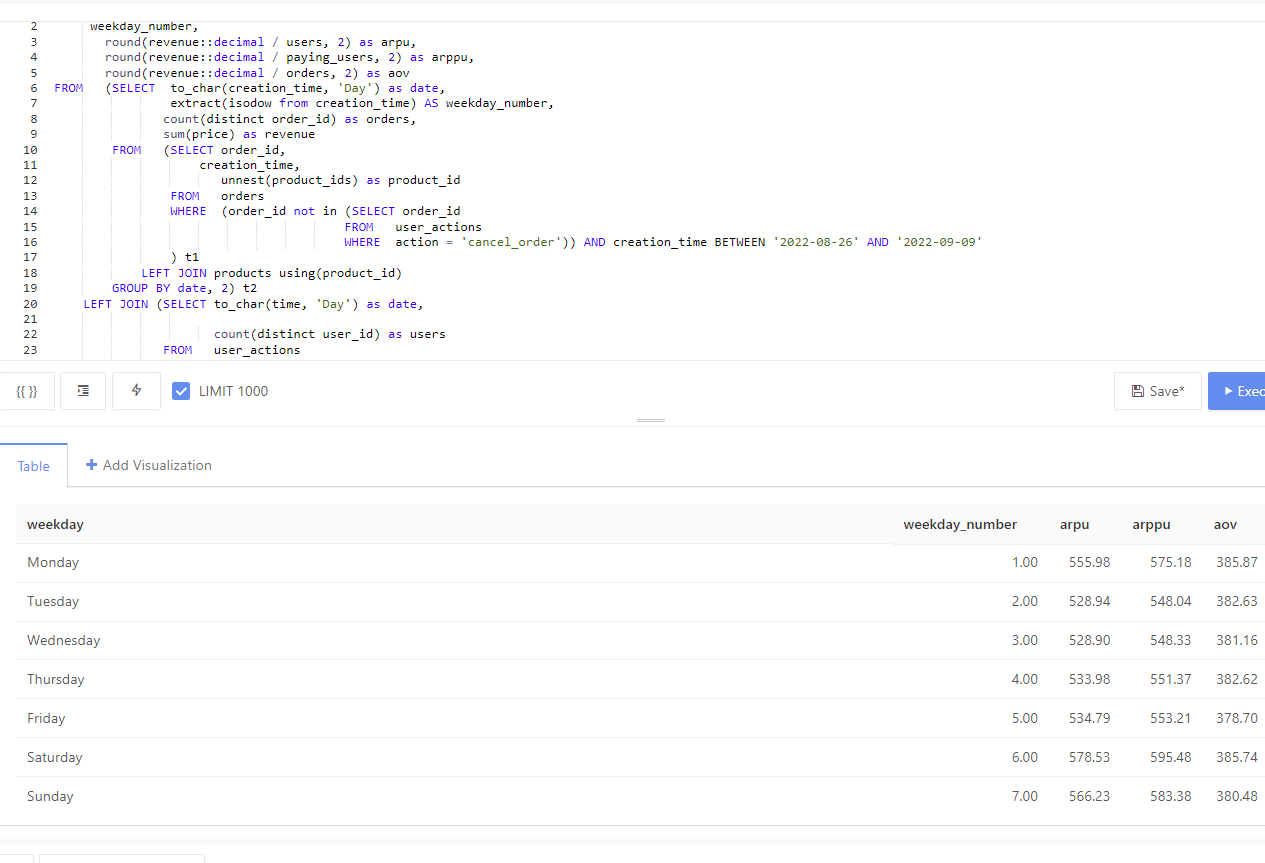

In [ ]:
# Вариант верного решения
SELECT weekday,
       t1.weekday_number as weekday_number,
       round(revenue::decimal / users, 2) as arpu,
       round(revenue::decimal / paying_users, 2) as arppu,
       round(revenue::decimal / orders, 2) as aov
FROM   (SELECT to_char(creation_time, 'Day') as weekday,
               max(date_part('isodow', creation_time)) as weekday_number,
               count(distinct order_id) as orders,
               sum(price) as revenue
        FROM   (SELECT order_id,
                       creation_time,
                       unnest(product_ids) as product_id
                FROM   orders
                WHERE  order_id not in (SELECT order_id
                                        FROM   user_actions
                                        WHERE  action = 'cancel_order')
                   and creation_time >= '2022-08-26'
                   and creation_time < '2022-09-09') t4
            LEFT JOIN products using(product_id)
        GROUP BY weekday) t1
    LEFT JOIN (SELECT to_char(time, 'Day') as weekday,
                      max(date_part('isodow', time)) as weekday_number,
                      count(distinct user_id) as users
               FROM   user_actions
               WHERE  time >= '2022-08-26'
                  and time < '2022-09-09'
               GROUP BY weekday) t2 using (weekday)
    LEFT JOIN (SELECT to_char(time, 'Day') as weekday,
                      max(date_part('isodow', time)) as weekday_number,
                      count(distinct user_id) as paying_users
               FROM   user_actions
               WHERE  order_id not in (SELECT order_id
                                       FROM   user_actions
                                       WHERE  action = 'cancel_order')
                  and time >= '2022-08-26'
                  and time < '2022-09-09'
               GROUP BY weekday) t3 using (weekday)
ORDER BY weekday_number

In [ ]:
# Чужое
WITH 
    revenue_counter AS 
    (SELECT weekday, revenue, SUM(revenue) OVER(ORDER BY weekday) total_revenue,
        ROUND(100*(revenue::DECIMAL/(LAG(revenue, 1) OVER(ORDER BY weekday)) -1),2) revenue_change
    FROM
        (SELECT Weekday, SUM(order_price) revenue
        FROM
            (SELECT DISTINCT order_id, to_char(creation_time, 'Day') weekday,
                SUM(price) OVER(PARTITION BY order_id) order_price
            FROM orders,
              LATERAL unnest(product_ids) AS product_id
              LEFT JOIN products USING(product_id)
              WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action = 'cancel_order')
              AND creation_time BETWEEN '2022-08-26' AND '2022-09-09') T1
        GROUP BY weekday) T2),
        
    paying_users AS
    (SELECT COUNT(DISTINCT user_id) paying_users, to_char(time, 'Day') weekday
    FROM user_actions 
    WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action ~~ 'ca%')
    AND time BETWEEN '2022-08-26' AND '2022-09-09'
    GROUP BY weekday),
            
    total_users AS
    (SELECT COUNT(DISTINCT user_id) total_users, to_char(time, 'Day') weekday 
    FROM user_actions
    WHERE time BETWEEN '2022-08-26' AND '2022-09-09'
    GROUP BY weekday),
                
    order_counter AS            
    (SELECT to_char(time, 'Day') weekday, EXTRACT(isodow FROM time) weekday_number, COUNT(DISTINCT order_id) total_orders
    FROM user_actions 
    WHERE order_id NOT IN (SELECT order_id FROM user_actions WHERE action ~~ 'ca%')
    AND time BETWEEN '2022-08-26' AND '2022-09-09'
    GROUP BY weekday, weekday_number)
    
SELECT weekday, weekday_number,
    ROUND(revenue::DECIMAL/total_users, 2) ARPU,
    ROUND(revenue::DECIMAL/paying_users, 2) ARPPU,
    ROUND(revenue::DECIMAL/total_orders, 2) AOV
FROM 
    (SELECT weekday, weekday_number, revenue, total_users, paying_users, total_orders
    FROM revenue_counter 
        JOIN total_users USING(weekday)
        JOIN paying_users USING(weekday)
        JOIN order_counter USING(weekday)) CORE_QUERY
ORDER BY weekday_number



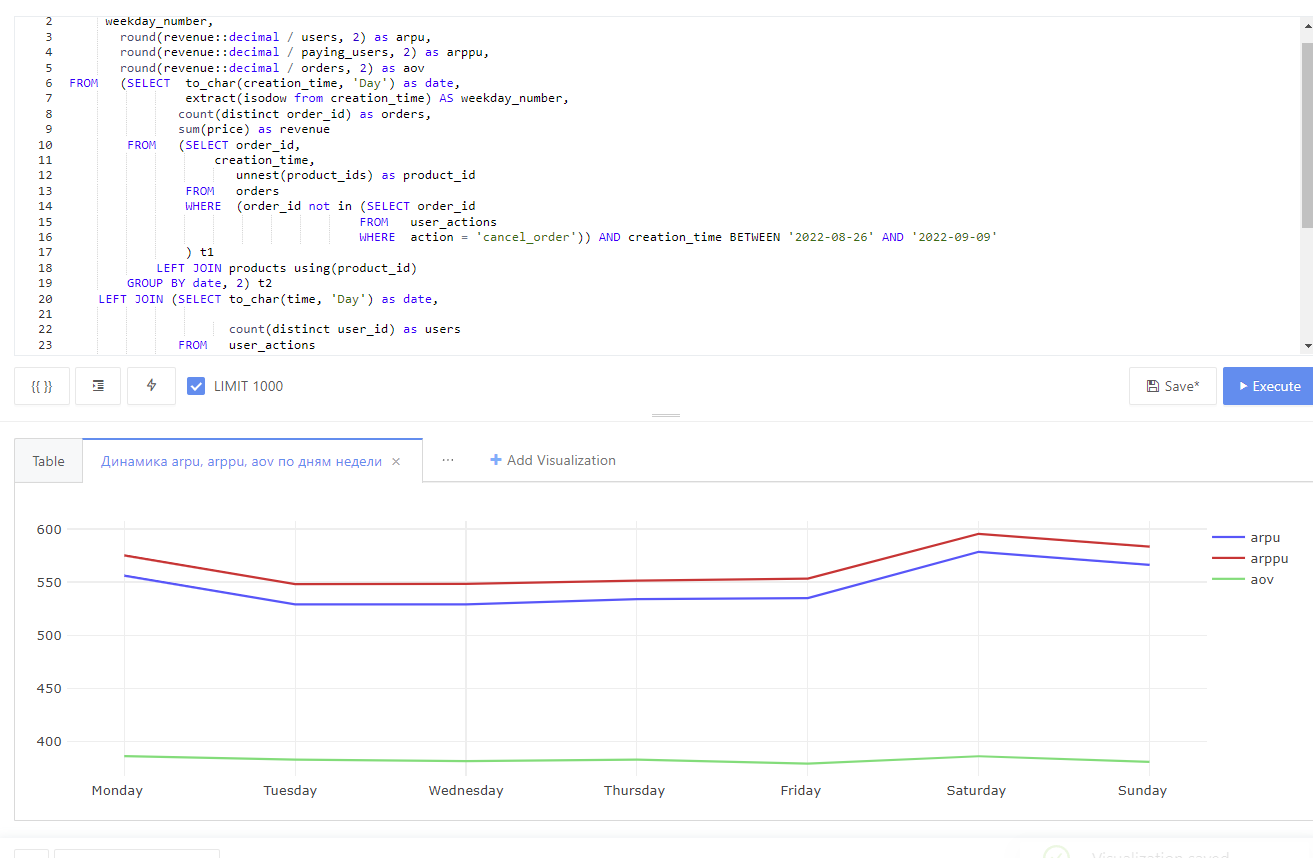

###### Проанализируйте построенный график и попробуйте ответить на следующие вопросы:

1.  В какие дни недели метрики ARPU и ARPPU принимали наибольшие значения? Как вы считаете, согласуется ли это в целом со стандартным поведением пользователей сервиса доставки еды?

2.  Как вы считаете, почему в те дни, когда метрики ARPU и ARPPU принимали наибольшие значения, метрика AOV оставалась примерно на том же уровне? При каком сценарии такое возможно?



## * Задача 5.
Немного усложним наш первоначальный запрос и отдельно посчитаем ежедневную выручку с заказов новых пользователей нашего сервиса. Посмотрим, какую долю она составляет в общей выручке с заказов всех пользователей — и новых, и старых.

Задание:

Для каждого дня в таблицах orders и user_actions рассчитайте следующие показатели:

    Выручку, полученную в этот день.
    Выручку с заказов новых пользователей, полученную в этот день.
    Долю выручки с заказов новых пользователей в общей выручке, полученной за этот день.
    Долю выручки с заказов остальных пользователей в общей выручке, полученной за этот день.
Колонки с показателями назовите соответственно revenue, new_users_revenue, new_users_revenue_share, old_users_revenue_share. Колонку с датами назовите date. 

Все показатели долей необходимо выразить в процентах. При их расчёте округляйте значения до двух знаков после запятой.

Результат должен быть отсортирован по возрастанию даты.

Поля в результирующей таблице:

date, revenue, new_users_revenue, new_users_revenue_share, old_users_revenue_share

Пояснение: 

Будем считать, что оплата за заказ поступает сразу же после его оформления, т.е. случаи, когда заказ был оформлен в один день, а оплата получена на следующий, возникнуть не могут.

Новыми будем считать тех пользователей, которые в данный день совершили своё первое действие в нашем сервисе.

При расчёте выручки помните, что не все заказы были оплачены — некоторые были отменены пользователями.

Не забывайте при делении заранее приводить значения к нужному типу данных.

##### Подсказка на случай, если совсем не получается

Для решения задачи необходимо для каждого дня посчитать выручку с новых пользователей. Чтобы это сделать, сначала необходимо для каждого пользователя определить минимальную дату, то есть дату первого действия в нашем сервисе, а также посчитать стоимость каждого заказа в таблице orders. Затем, объединив данные о стоимости заказов с данными о действиях пользователей в таблице user_actions, можно для каждого пользователя посчитать суммарную стоимость его заказов на каждую дату (группировка по двум полям) и объединить эти данные с таблицей с датами начала использования приложения у каждого пользователя (посчитанной ранее). Таким образом, можно получить таблицу с выручкой, полученной с каждого пользователя в его первый день. Далее остается сделать группировку по дате и посчитать суммарную выручку с новых пользователей за каждый день. Общую выручку за каждый день мы считали в предыдущих заданиях.

После того как составите запрос, попробуйте визуализировать результаты и постройте график, отражающий динамику рассчитанных показателей.

